# Introduction

This notebook includes evaluation of modeling process to test the effectiveness against an unseen data - post that can potential determine from which subreddit it is from. Using the metrics of F1 and ROC score to check which is best to classify the predictions and test it on new datas.

## Import Libraries

In [1]:
# library imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# preprocessing imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# modeling imports
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, plot_roc_curve, roc_auc_score

In [2]:
# Import clean data
df = pd.read_csv('./datasets/data_clean.csv')

In [3]:
df.head()

,id,author,created_utc,subreddit,selftext,title,subreddit_labels
0,l1n3vd,Jeffamazon,2021-01-21 00:52:21,GME,stumbl upon sub know exist join gme gang back ...,greet gme gang,0
1,l1wi6q,B1ake1,2021-01-21 11:13:54,GME,hold line share,rememb lad scare money make money,0
2,l22dsa,Dustin_James_Kid,2021-01-21 16:55:19,GME,i new tri learn stock scare know access info s...,know squeez happen,0
3,l22r5n,MailNurse,2021-01-21 17:11:48,GME,price sub,fuck reinforc,0
4,l2359i,imalwright,2021-01-21 17:29:43,GME,pick gme dip let u hope need hsa year i deep gme,pick,0


### Features

In [4]:
# Define X and y features
X = df[['selftext','title']]
y = df['subreddit_labels']

### Baseline Data Ratio

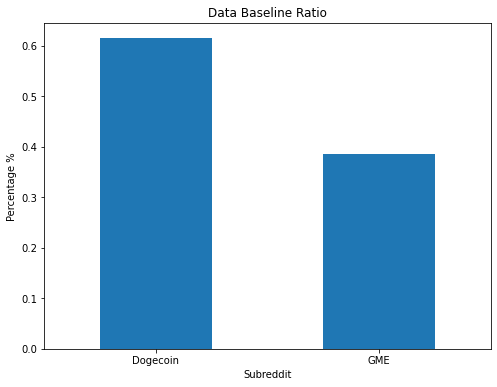

In [5]:
# Check baseline of data
plt.figure(figsize=(8, 6))
y.value_counts(normalize = True).plot(kind='bar')

# Graph descriptions
positions = (0, 1)
labels = ("Dogecoin", "GME")

plt.title('Data Baseline Ratio')
plt.xlabel('Subreddit')
plt.ylabel('Percentage %')
plt.xticks(positions, labels, rotation=0);

### Split data to train and test

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

## Preliminary Exploratory Data Analysis

### CountVectorizer - selftext

13026


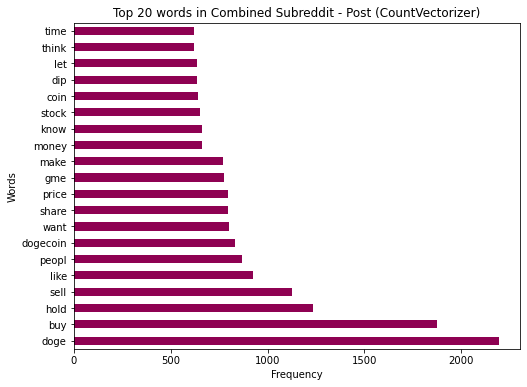

In [8]:
# Identifying top words in 'selftext' using CountVectorizer with cleaned data

# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words='english')

# Fit df to transformer 
cvec.fit(X_train['selftext'])

# Check total number of words
len_features = len(cvec.get_feature_names())
print(len_features)

# Transform data and create a df
df_cv = pd.DataFrame(cvec.transform(X_train['selftext']).todense(),columns=cvec.get_feature_names())

# Visualize top 20 words in 'selftext'
plt.figure(figsize=(8, 6))
df_cv.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='PiYG');
plt.title('Top 20 words in Combined Subreddit - Post (CountVectorizer)');
plt.xlabel('Frequency');
plt.ylabel('Words');

### TfidfVectorizer - selftext

13026


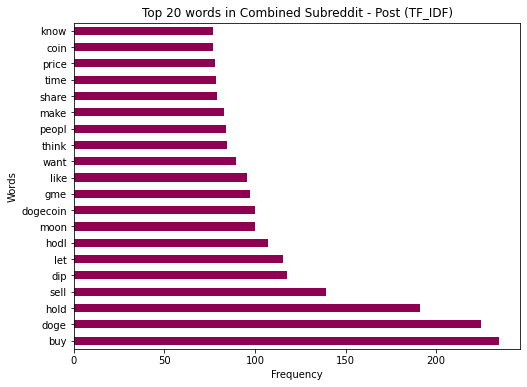

In [9]:
# Identifying top words in 'selftext' using TfidVectorizer with cleaned data

# Instantiate TfidVectorizer
tvec = TfidfVectorizer(stop_words='english')

# Fit df to transformer 
tvec.fit(X_train['selftext'])

# Check total number of features
len_features = len(tvec.get_feature_names())
print(len_features)

# Transform data and create a df
df_tf_idf = pd.DataFrame(tvec.transform(X_train['selftext']).todense(),columns=tvec.get_feature_names())

# Visualize top 20 words in 'selftext'
plt.figure(figsize=(8, 6))
df_tf_idf.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='PiYG');
plt.title('Top 20 words in Combined Subreddit - Post (TF_IDF)');
plt.xlabel('Frequency');
plt.ylabel('Words');

##### Observations:
- majority of the top words are similar for both data 

### CountVectorizer - title

3387


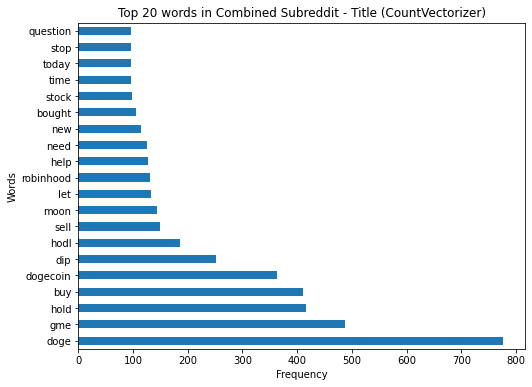

In [10]:
# Identifying top words in 'title' using CountVectorizer with cleaned data

# CountVectorizer instatiate earlier 
# Fit df to transformer
cvec.fit(X_train['title'])

# Check total number of features
len_features = len(cvec.get_feature_names())
print(len_features)

# Transform data and create a df
df_cv2 = pd.DataFrame(cvec.transform(X_train['title']).todense(),columns=cvec.get_feature_names())

# Visualize top 20 words in ' title'
plt.figure(figsize=(8, 6))
df_cv2.sum().sort_values(ascending=False).head(20).plot(kind='barh');
plt.title('Top 20 words in Combined Subreddit - Title (CountVectorizer)');
plt.xlabel('Frequency');
plt.ylabel('Words');

### TfidfVectorizer - title

3387


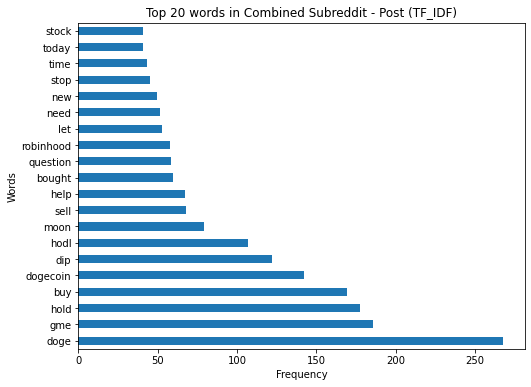

In [11]:
# Identifying top words in 'title' using TfidVectorizer with cleaned data

# TfidVectorizer instatiate earlier 
# Fit df to transformer 
tvec.fit(X_train['title'])

# Check total number of features
len_features = len(tvec.get_feature_names())
print(len_features)

# Transform data and create a df
df_tf_idf2 = pd.DataFrame(tvec.transform(X_train['title']).todense(),columns=tvec.get_feature_names())

# Visualize top 20 words in 'title'
plt.figure(figsize=(8, 6))
df_tf_idf2.sum().sort_values(ascending=False).head(20).plot(kind='barh');
plt.title('Top 20 words in Combined Subreddit - Post (TF_IDF)');
plt.xlabel('Frequency');
plt.ylabel('Words');

## Model Preprocessing - Selftext

Perform gridsearch for transformers (CountVectorizer or TfidVectorizer) to determine which type of transformer and its parameter that best suit a base model for classification problems

In [12]:
# Create dataframe to store result of gridsearch for transformers
results = pd.DataFrame(columns=['model','best_params','train_score','test_score'])

In [13]:
# List of models
models = ['nb', 'logreg', 'rf']

### CountVectorizer

In [14]:
# list of transfomer and models to include in the pipeline
list_pipes_cv = [ 
    [('cv',CountVectorizer()),('nb',MultinomialNB())],
    [('cv',CountVectorizer()),('logreg',LogisticRegression())],
    [('cv',CountVectorizer()),('rf',RandomForestClassifier())]
]

In [15]:
# Set hyperparameters for CountVectorizer()
pipe_params_cv = [
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]},
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]},
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]}
]

In [16]:
# To identify best CountVectorizer for each base models
for i in range(len(list_pipes_cv)): # Loop to identify index for list pipes
    pipe = Pipeline(steps=list_pipes_cv[i]) # Instantiate pipeline
    gs = GridSearchCV(pipe, pipe_params_cv[i], cv=5) # Instantiate GridSearchCV
    
    # Storing results temporarily in loop
    temp = {}
    
    # Fit GridSearchCV
    gs.fit(X_train['selftext'], y_train)
    
    # Assign results to dictionary and append to dataframe - results
    temp['model'] = models[i]
    temp['best_params'] = gs.best_params_
    temp['train_score'] = gs.score(X_train['selftext'], y_train)
    temp['test_score'] = gs.score(X_test['selftext'], y_test)
    results = results.append(temp, ignore_index=True)
    
    print ('--------------------------------------------------------------------------------')
    print (pipe)
    print (f'Train score: {temp["train_score"]}')
    print (f'Test score: {temp["test_score"]}')
    print ('')
    print(f'Best parameters are: {temp["best_params"]}')

--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])
Train score: 0.9219562955254943
Test score: 0.8722280887011615

Best parameters are: {'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('logreg', LogisticRegression())])
Train score: 0.9334027055150884
Test score: 0.8637803590285111

Best parameters are: {'cv__min_df': 5, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])
Train score: 0.992542490461325
Test score: 0.8651883139739528

Best parameters are: {'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}


### TfidfVectorizer

In [17]:
# list of transfomer and models to include in the pipeline
list_pipes_tf = [ 
    [('tf',TfidfVectorizer()),('nb',MultinomialNB())],
    [('tf',TfidfVectorizer()),('logreg',LogisticRegression())],
    [('tf',TfidfVectorizer()),('rf',RandomForestClassifier())]
]

In [18]:
# Set hyperparameters for TfidfVectorizer()
pipe_params_tf = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]}
]

In [19]:
# To identify best TfiVectorizer for each base models
for i in range(len(list_pipes_tf)): # Loop to identify index for list pipes
    pipe = Pipeline(steps=list_pipes_tf[i]) # Instantiate pipeline
    gs = GridSearchCV(pipe, pipe_params_tf[i], cv=5) # Instantiate GridSearchCV
    
    # Storing results temporarily in loop
    temp = {}

    # Fit GridSearchCV
    gs.fit(X_train['selftext'], y_train)
    
    # Assign results to dictionary and append to dataframe - results
    temp['model'] = models[i]
    temp['best_params'] = gs.best_params_
    temp['train_score'] = gs.score(X_train['selftext'], y_train)
    temp['test_score'] = gs.score(X_test['selftext'], y_test)
    results = results.append(temp, ignore_index=True)
    
    print ('--------------------------------------------------------------------------------')
    print (pipe)
    print (f'Train score: {temp["train_score"]}')
    print (f'Test score: {temp["test_score"]}')
    print ('')
    print(f'Best parameters are: {temp["best_params"]}')

--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('nb', MultinomialNB())])
Train score: 0.8928199791883454
Test score: 0.8627243928194298

Best parameters are: {'tf__min_df': 5, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('logreg', LogisticRegression())])
Train score: 0.9079084287200833
Test score: 0.8655403027103132

Best parameters are: {'tf__min_df': 4, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
Train score: 0.9861255636489767
Test score: 0.8718760999648011

Best parameters are: {'tf__min_df': 2, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


### Results of best transformer

In [20]:
# Create a column to see the difference in train and test score for each transformer
results['variance'] =  results['train_score'] - results['test_score']

In [21]:
results

,model,best_params,train_score,test_score,variance
0,nb,"{'cv__min_df': 1, 'cv__ngram_range': (1, 1), '...",0.921956,0.872228,0.049728
1,logreg,"{'cv__min_df': 5, 'cv__ngram_range': (1, 1), '...",0.933403,0.863780,0.069622
2,rf,"{'cv__min_df': 1, 'cv__ngram_range': (1, 1), '...",0.992542,0.865188,0.127354
3,nb,"{'tf__min_df': 5, 'tf__ngram_range': (1, 1), '...",0.892820,0.862724,0.030096
4,logreg,"{'tf__min_df': 4, 'tf__ngram_range': (1, 1), '...",0.907908,0.865540,0.042368
5,rf,"{'tf__min_df': 2, 'tf__ngram_range': (1, 1), '...",0.986126,0.871876,0.114249


In [22]:
results[results['model'] == 'nb']

,model,best_params,train_score,test_score,variance
0,nb,"{'cv__min_df': 1, 'cv__ngram_range': (1, 1), '...",0.921956,0.872228,0.049728
3,nb,"{'tf__min_df': 5, 'tf__ngram_range': (1, 1), '...",0.892820,0.862724,0.030096


In [23]:
results[results['model'] == 'logreg']

,model,best_params,train_score,test_score,variance
1,logreg,"{'cv__min_df': 5, 'cv__ngram_range': (1, 1), '...",0.933403,0.86378,0.069622
4,logreg,"{'tf__min_df': 4, 'tf__ngram_range': (1, 1), '...",0.907908,0.86554,0.042368


In [24]:
results[results['model'] == 'rf']

,model,best_params,train_score,test_score,variance
2,rf,"{'cv__min_df': 1, 'cv__ngram_range': (1, 1), '...",0.992542,0.865188,0.127354
5,rf,"{'tf__min_df': 2, 'tf__ngram_range': (1, 1), '...",0.986126,0.871876,0.114249


#### Observations

Transformers that performs best:
- multinomialnb: TfidfVectorizer (stop_words='english', ngram_range=(1,1), min_df=5)
- logreg: TfidVectorizer (stop_words='english', ngram_range=(1,1), min_df=4)
- rf: TfidfVectorizer (stop_words='english', ngram_range=(1,1), min_df=2)

## Classification Models - Selftext

In [25]:
# Create dataframe to store results of gridsearch for models
model_results = pd.DataFrame(columns=['models', 'best_params', 'train_score', 'test_score', 'f1_score'])

### MultinomialNB

In [26]:
# Set hyperparameters for multinomialNB
pipe_params_nb = [{"nb__alpha":np.arange(1,5,.1)}]

In [27]:
# To identify best hyperparameters for MultinomilNB 

# Instantiate pipeline
pipe = Pipeline([
    ('cv', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=5)),
    ('nb', MultinomialNB())
])

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, pipe_params_nb, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

#Fit GridSearchCV
gs.fit(X_train['selftext'], y_train)

# Find predictors
preds = gs.predict(X_test['selftext'])

# Assign results to dictionary and append to dataframe - model_results
temp_mod['models'] = 'nb'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['selftext'], y_train)
temp_mod['test_score'] = gs.score(X_test['selftext'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results = model_results.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv', TfidfVectorizer(min_df=5, stop_words='english')),
                ('nb', MultinomialNB())])

Train score: 0.8928199791883454
Test score: 0.8627243928194298

F1 score: 0.8954983922829581

Best parameters are: {'nb__alpha': 1.0}


### Logistic Regression

In [28]:
pipe_params_logreg = [{"logreg__penalty":['l2'],
                       "logreg__C": np.arange(1, 5, 0.1),
                       "logreg__max_iter": [4000]}]

In [29]:
# To identify best parameter for LogisticRegression 

# Instantiate pipeline
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=4)),
    ('logreg', LogisticRegression())
])

# Fit GridSearchCV
gs = GridSearchCV(pipe, pipe_params_logreg, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

#Fit GridSearchCV
gs.fit(X_train['selftext'], y_train)

# Find predictors
preds = gs.predict(X_test['selftext'])

# Assign results to dictionary and append to dataframe - model_results
temp_mod['models'] = 'logreg'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['selftext'], y_train)
temp_mod['test_score'] = gs.score(X_test['selftext'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results = model_results.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv', TfidfVectorizer(min_df=4, stop_words='english')),
                ('logreg', LogisticRegression())])

Train score: 0.921436004162331
Test score: 0.866948257655755

F1 score: 0.8953488372093024

Best parameters are: {'logreg__C': 1.8000000000000007, 'logreg__max_iter': 4000, 'logreg__penalty': 'l2'}


### Random Forest

In [30]:
# Set hyperparamaters for RandomForestClassifier
pipe_params_rf = [{"rf__n_estimators":np.arange(100, 200, 20),
                   "rf__max_depth": [None, 1, 2, 3, 4, 5]}]

In [31]:
# To identify best parameter for RandomForestClassifier
# Instantiate pipeline
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
    ('rf', RandomForestClassifier())
])

# Fit GridSearchCV
gs = GridSearchCV(pipe, pipe_params_rf, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

#Fit GridSearchCV
gs.fit(X_train['selftext'], y_train)

# Find predictors
preds = gs.predict(X_test['selftext'])

# Assign results to dictionary and append to dataframe - model_results
temp_mod['models'] = 'rf'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['selftext'], y_train)
temp_mod['test_score'] = gs.score(X_test['selftext'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results = model_results.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv', TfidfVectorizer(min_df=2, stop_words='english')),
                ('rf', RandomForestClassifier())])

Train score: 0.9861255636489767
Test score: 0.8704681450193594

F1 score: 0.8989010989010989

Best parameters are: {'rf__max_depth': None, 'rf__n_estimators': 180}


### Result of best model

In [32]:
model_results

,models,best_params,train_score,test_score,f1_score
0,nb,{'nb__alpha': 1.0},0.892820,0.862724,0.895498
1,logreg,"{'logreg__C': 1.8000000000000007, 'logreg__max...",0.921436,0.866948,0.895349
2,rf,"{'rf__max_depth': None, 'rf__n_estimators': 180}",0.986126,0.870468,0.898901


## Evaluate Model with Metrics

### Function 

In [33]:
# Function to measure model performance with classification metrics
def eva_metrics(y_test, preds, X_test):

    # Save TN/FP/FN/TP values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Using sklearn - accuracy score and F1 score to determine model accuracy
    print (f'Accuracy score: {accuracy_score(y_test, preds)}')
    print (f'F1 score: {f1_score(y_test, preds)}')
    print ('--------------------------------------------------------------------------')
    print ('')

    print ("True Negatives: %s" % tn)
    print ("False Positives: %s" % fp)
    print ("False Negatives: %s" % fn)
    print ("True Positives: %s" % tp)
    print('')
    
    # Plot confusion matrix
    plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d', display_labels=['0', '1']);
    
    print (f'Dogecoin predicted correctly: {tp / (tp + fn)}')
    print (f'GME predicted correctly: {tn / (tn + fp)}')

#### Model best transformers & hyperparameters:

Transfomers
- TfidfVectorizer (stop_words='english', ngram_range=(1,1), min_df=2)

Models
- rf: (max_depth=None, n_estimators=160)

In [34]:
# Set hyperparameters
rf_pipe = [
    ('tf',TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
    ('rf',RandomForestClassifier(max_depth=None, n_estimators=160))
    ]

In [35]:
# Create a multinomialnb with best hyperparameters

# Instatiate pipeline
pipe = Pipeline(rf_pipe)

# Fit pipeline
pipe.fit(X_train['selftext'], y_train)

# Check model score (underfit or overfit)
train_score = pipe.score(X_train['selftext'], y_train)
test_score = pipe.score(X_test['selftext'], y_test)
cv_score = cross_val_score(pipe, X_train['selftext'], y_train, cv=5).mean()
cv_score2 = cross_val_score(pipe, X_test['selftext'], y_test, cv=5).mean()

print (f'CV score: {cv_score}')
print (f'CV score: {cv_score2}')
print('')
print (f'Train score: {train_score}')
print (f'Test score: {test_score}')

# Generate predictions
preds = pipe.predict(X_test['selftext'])

CV score: 0.8598689876909156
CV score: 0.8606122676303869

Train score: 0.9861255636489767
Test score: 0.8637803590285111


Accuracy score: 0.8637803590285111
F1 score: 0.8936521022258862
--------------------------------------------------------------------------

True Negatives: 828
False Positives: 266
False Negatives: 121
True Positives: 1626

Dogecoin predicted correctly: 0.9307384087006296
GME predicted correctly: 0.7568555758683729


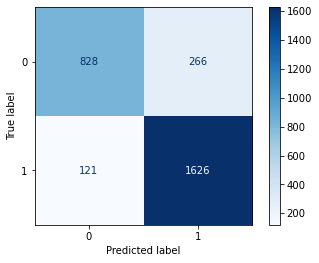

In [36]:
eva_metrics(y_test, preds, X_test['selftext'])

In [37]:
# Create dataframe for predictors 
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pipe.predict_proba(X_test['selftext'])[:,1]})

pred_df.head()

,true_values,pred_probs
4008,1,0.697222
1919,0,0.216750
4000,1,0.895913
3270,0,0.037500
5735,1,0.911979


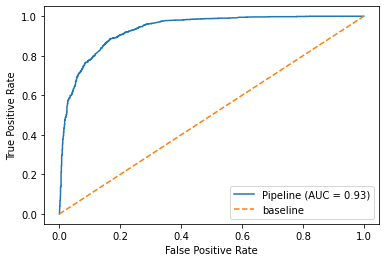

In [38]:
# Plot ROC-AUC graph
plot_roc_curve(pipe, X_test['selftext'], y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [39]:
rocauc_score = roc_auc_score(y_test, pipe.predict_proba(X_test['selftext'])[:,1])
print (f'ROC_AUC score: {rocauc_score}')

ROC_AUC score: 0.9333561111291334


## Model Preprocessing - Title

In [40]:
# Create dataframe to store result of gridsearch for transformers
results2 = pd.DataFrame(columns=['model','best_params','train_score','test_score'])

In [41]:
# List of models
models = ['nb', 'logreg', 'rf']

### CountVectorizer

In [42]:
# list of transfomer and models to include in the pipeline
list_pipes_cv = [ 
    [('cv',CountVectorizer()),('nb',MultinomialNB())],
    [('cv',CountVectorizer()),('logreg',LogisticRegression())],
    [('cv',CountVectorizer()),('rf',RandomForestClassifier())]
]

In [43]:
# Set hyperparameters for CountVectorizer()
pipe_params_cv = [
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]},
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]},
    {"cv__stop_words":['english'], "cv__ngram_range":[(1,1),(1,2)], "cv__min_df":[1, 2, 3, 4, 5]}
]

In [44]:
# To identify best countvectorizer for each base models
for i in range(len(list_pipes_cv)): # Loop to identify index for list pipes
    pipe = Pipeline(steps=list_pipes_cv[i]) # Instantiate pipeline
    gs = GridSearchCV(pipe, pipe_params_cv[i], cv=5) # Instantiate GridSearchCV
    
    # Storing results temporarily in loop
    temp = {}
    
    # Fit GridSearchCV
    gs.fit(X_train['title'], y_train)
    
    # Assign results to dictionary and append to dataframe - results2
    temp['model'] = models[i]
    temp['best_params'] = gs.best_params_
    temp['train_score'] = gs.score(X_train['title'], y_train)
    temp['test_score'] = gs.score(X_test['title'], y_test)
    results2 = results2.append(temp, ignore_index=True)
    
    print ('--------------------------------------------------------------------------------')
    print (pipe)
    print (f'Train score: {temp["train_score"]}')
    print (f'Test score: {temp["test_score"]}')
    print ('')
    print(f'Best parameters are: {temp["best_params"]}')

--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])
Train score: 0.9424210891432535
Test score: 0.837029215065118

Best parameters are: {'cv__min_df': 1, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('logreg', LogisticRegression())])
Train score: 0.894901144640999
Test score: 0.8363252375923971

Best parameters are: {'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])
Train score: 0.9741588622962192
Test score: 0.82259767687434

Best parameters are: {'cv__min_df': 1, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}


### TfidfVectorizer

In [45]:
# list of transfomer and models to include in the pipeline
list_pipes_tf = [ 
    [('tf',TfidfVectorizer()),('nb',MultinomialNB())],
    [('tf',TfidfVectorizer()),('logreg',LogisticRegression())],
    [('tf',TfidfVectorizer()),('rf',RandomForestClassifier())]
]

In [46]:
# Set hyperparameters for TfidfVectorizer()
pipe_params_tf = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)], "tf__min_df":[1, 2, 3, 4, 5]}
]

In [47]:
# To identify best countvectorizer for each base models
for i in range(len(list_pipes_tf)): # Loop to identify index for list pipes
    pipe = Pipeline(steps=list_pipes_tf[i]) # Instantiate pipeline
    gs = GridSearchCV(pipe, pipe_params_tf[i], cv=5) # Instantiate GridSearchCV
    
    # Storing results temporarily in loop
    temp = {}
    
    # Fit GridSearchCV
    gs.fit(X_train['title'], y_train)
    
    # Assign results to dictionary and append to dataframe - results2
    temp['model'] = models[i]
    temp['best_params'] = gs.best_params_
    temp['train_score'] = gs.score(X_train['title'], y_train)
    temp['test_score'] = gs.score(X_test['title'], y_test)
    results2 = results2.append(temp, ignore_index=True)
    
    print ('--------------------------------------------------------------------------------')
    print (pipe)
    print (f'Train score: {temp["train_score"]}')
    print (f'Test score: {temp["test_score"]}')
    print ('')
    print(f'Best parameters are: {temp["best_params"]}')

--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('nb', MultinomialNB())])
Train score: 0.8910856746444675
Test score: 0.8254135867652235

Best parameters are: {'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('logreg', LogisticRegression())])
Train score: 0.8779049601109955
Test score: 0.8335093277015135

Best parameters are: {'tf__min_df': 2, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
--------------------------------------------------------------------------------
Pipeline(steps=[('tf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
Train score: 0.9741588622962192
Test score: 0.8306934178106301

Best parameters are: {'tf__min_df': 1, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


### Results of best transformer

In [48]:
# Create a column to see the difference in train and test score for each transformer
results2['variance'] =  results2['train_score'] - results2['test_score']

In [49]:
results2

,model,best_params,train_score,test_score,variance
0,nb,"{'cv__min_df': 1, 'cv__ngram_range': (1, 2), '...",0.942421,0.837029,0.105392
1,logreg,"{'cv__min_df': 2, 'cv__ngram_range': (1, 2), '...",0.894901,0.836325,0.058576
2,rf,"{'cv__min_df': 1, 'cv__ngram_range': (1, 2), '...",0.974159,0.822598,0.151561
3,nb,"{'tf__min_df': 2, 'tf__ngram_range': (1, 2), '...",0.891086,0.825414,0.065672
4,logreg,"{'tf__min_df': 2, 'tf__ngram_range': (1, 1), '...",0.877905,0.833509,0.044396
5,rf,"{'tf__min_df': 1, 'tf__ngram_range': (1, 2), '...",0.974159,0.830693,0.143465


In [50]:
results2[results2['model'] == 'nb']

,model,best_params,train_score,test_score,variance
0,nb,"{'cv__min_df': 1, 'cv__ngram_range': (1, 2), '...",0.942421,0.837029,0.105392
3,nb,"{'tf__min_df': 2, 'tf__ngram_range': (1, 2), '...",0.891086,0.825414,0.065672


In [51]:
results2[results2['model'] == 'logreg']

,model,best_params,train_score,test_score,variance
1,logreg,"{'cv__min_df': 2, 'cv__ngram_range': (1, 2), '...",0.894901,0.836325,0.058576
4,logreg,"{'tf__min_df': 2, 'tf__ngram_range': (1, 1), '...",0.877905,0.833509,0.044396


In [52]:
results2[results2['model'] == 'rf']

,model,best_params,train_score,test_score,variance
2,rf,"{'cv__min_df': 1, 'cv__ngram_range': (1, 2), '...",0.974159,0.822598,0.151561
5,rf,"{'tf__min_df': 1, 'tf__ngram_range': (1, 2), '...",0.974159,0.830693,0.143465


#### Observations

Transformers that performs best:
- multinomialnb: TfidfVectorizer (stop_words='english', ngram_range=(1,2), min_df=2)
- logreg: TfidVectorizer (stop_words='english', ngram_range=(1,1), min_df=2)
- rf: TfidfVectorizer (stop_words='english', ngram_range=(1,2), min_df=1)

## Classification Model - Title

In [60]:
# Create dataframe to store results of gridsearch for models
model_results2 = pd.DataFrame(columns=['models', 'best_params', 'train_score', 'test_score', 'f1_score'])

### MultinomialNB

In [61]:
# Set hyperparameters for MultinomialNB
pipe_params_nb2 = [{"nb__alpha":np.arange(1,5,.1)}]

In [62]:
# To identify best parameter for MultinomilNB 

# Instantiate pipeline
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
    ('nb', MultinomialNB())
])

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, pipe_params_nb2, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

# Fit GridSearchCV
gs.fit(X_train['title'], y_train)

# Find predictors
preds = gs.predict(X_test['title'])

# Assign results to dictionary and append to dataframe - model_results2
temp_mod['models'] = 'nb'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['title'], y_train)
temp_mod['test_score'] = gs.score(X_test['title'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results2 = model_results2.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('nb', MultinomialNB())])

Train score: 0.8910856746444675
Test score: 0.8254135867652235

F1 score: 0.867237687366167

Best parameters are: {'nb__alpha': 1.0}


### Logistic Regression

In [63]:
pipe_params_logreg2 = [{"logreg__penalty":['l2'],
                       "logreg__C": np.arange(1, 5, 0.1),
                       "logreg__max_iter": [4000]}]

In [64]:
# To identify best parameter for LogisticRegression 

# Instantiate pipeline
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
    ('logreg', LogisticRegression())
])

# Instantiate GridSearchCV
gs = GridSearchCV(pipe, pipe_params_logreg2, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

# Fit GridSearchCV
gs.fit(X_train['title'], y_train)

# Find predictors
preds = gs.predict(X_test['title'])

# Assign results to dictionary and append to dataframe - model_results
temp_mod['models'] = 'logreg'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['title'], y_train)
temp_mod['test_score'] = gs.score(X_test['title'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results2 = model_results2.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv', TfidfVectorizer(min_df=2, stop_words='english')),
                ('logreg', LogisticRegression())])

Train score: 0.8810267082899758
Test score: 0.833861316437874

F1 score: 0.8739989321943407

Best parameters are: {'logreg__C': 1.1, 'logreg__max_iter': 4000, 'logreg__penalty': 'l2'}


### Random Forest

In [65]:
# Set hyperparamaters for RandomForestClassifier
pipe_params_rf2= [{"rf__n_estimators":np.arange(100, 200, 20),
                   "rf__max_depth": [None, 1, 2, 3, 4, 5]}]

In [66]:
# To identify best parameter for RandomForestClassifier
# Instantiate pipeline
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=1)),
    ('rf', RandomForestClassifier())
])

# Fit GridSearchCV
gs = GridSearchCV(pipe, pipe_params_rf2, cv=5) 

# Storing results temporarily in loop
temp_mod = {}

# Fit GridSearchCV
gs.fit(X_train['title'], y_train)

# Find predictors
preds = gs.predict(X_test['title'])

# Assign results to dictionary and append to dataframe - model_results2
temp_mod['models'] = 'rf'
temp_mod['best_params'] = gs.best_params_
temp_mod['train_score'] = gs.score(X_train['title'], y_train)
temp_mod['test_score'] = gs.score(X_test['title'], y_test)
temp_mod['f1_score'] = f1_score(y_test, preds)
model_results2 = model_results2.append(temp_mod, ignore_index=True)

print (pipe)
print ('')
print (f'Train score: {temp_mod["train_score"]}')
print (f'Test score: {temp_mod["test_score"]}')
print ('')
print (f'F1 score: {temp_mod["f1_score"]}')
print ('')
print(f'Best parameters are: {temp_mod["best_params"]}')

Pipeline(steps=[('cv',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('rf', RandomForestClassifier())])

Train score: 0.9741588622962192
Test score: 0.8261175642379444

F1 score: 0.8634604754007739

Best parameters are: {'rf__max_depth': None, 'rf__n_estimators': 140}


### Result of best model

In [67]:
model_results2

,models,best_params,train_score,test_score,f1_score
0,nb,{'nb__alpha': 1.0},0.891086,0.825414,0.867238
1,logreg,"{'logreg__C': 1.1, 'logreg__max_iter': 4000, '...",0.881027,0.833861,0.873999
2,rf,"{'rf__max_depth': None, 'rf__n_estimators': 140}",0.974159,0.826118,0.863460


#### Model best transformers & hyperparameters:

Transfomers
- TfidfVectorizer (stop_words='english', ngram_range=(1,1), min_df=2)

Models
- logreg: (C=1.1, max_iter=4000, penalty='l2')

In [68]:
logreg_pipe2 = [
    ('tf', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
    ('logreg', LogisticRegression(C=1.1, max_iter=4000, penalty='l2'))
    ]

In [69]:
# Create a multinomialnb with best hyperparameters

# Instatiate pipeline
pipe = Pipeline(logreg_pipe2)

# Fit pipeline
pipe.fit(X_train['title'], y_train)

# Check model score (underfit or overfit)
train_score = pipe.score(X_train['title'], y_train)
test_score = pipe.score(X_test['title'], y_test)
cv_score = cross_val_score(pipe, X_train['title'], y_train, cv=5).mean()
cv_score2 = cross_val_score(pipe, X_test['title'], y_test, cv=5).mean()

print (f'CV score: {cv_score}')
print (f'CV score: {cv_score2}')
print('')
print (f'Train score: {train_score}')
print (f'Test score: {test_score}')

# Generate predictions
preds = pipe.predict(X_test['title'])

CV score: 0.8392298893249619
CV score: 0.8137930394316693

Train score: 0.8810267082899758
Test score: 0.833861316437874


Accuracy score: 0.833861316437874
F1 score: 0.8739989321943407
--------------------------------------------------------------------------

True Negatives: 732
False Positives: 362
False Negatives: 110
True Positives: 1637

Dogecoin predicted correctly: 0.9370349170005724
GME predicted correctly: 0.6691042047531993


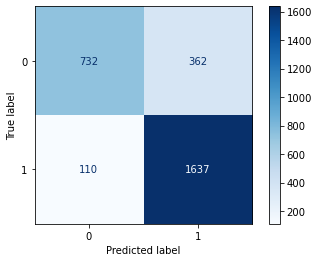

In [70]:
eva_metrics(y_test, preds, X_test['title'])

In [71]:
# Create dataframe for predictors
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pipe.predict_proba(X_test['title'])[:,1]})

pred_df.head()

,true_values,pred_probs
4008,1,0.986362
1919,0,0.647355
4000,1,0.970546
3270,0,0.063644
5735,1,0.861430


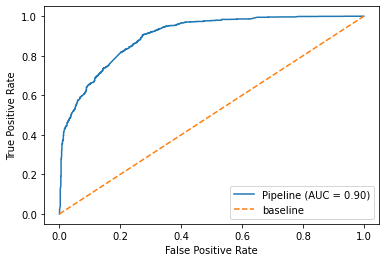

In [72]:
# Plot ROC-AUC graph
plot_roc_curve(pipe, X_test['title'], y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [73]:
rocauc_score = roc_auc_score(y_test, pipe.predict_proba(X_test['title'])[:,1])
print (f'ROC_AUC score: {rocauc_score}')

ROC_AUC score: 0.8998471132021572


In [ ]:
# y_pred2 = pd.DataFrame(preds, columns=["prediction"])

In [ ]:
# y_pred2['prediction'].value_counts()

### Evaluation of Score

#### Post
- Best model: CountVectorizer (stop_words='english', ngram_range=(1,1), min_df= ) with MultinomialNB(alpha=1)
- F1 score: 0.8936521022258862
- ROC-AUC score: 0.9333561111291334

#### Title
- Best model: TF-IDF (stop_words='english', ngram_range=(1,2), min_df= ) with MultinomialNB(alpha=1)
- F1 score: 0.8739989321943407
- ROC-AUC score: 0.8998471132021572

# Conclusion & Recommendations

### Conclusion
We identify requirements of the problem statement (approach using Natural Language Processing (NLP) and events that cause an increase in share price) needed and extracted the data from individual subreddits (r/GME & r/dogecoin). 

Preliminary exploratory data analysis was done to understand the characteristic such as common words, frequency and distribution of words and characters for both post and title. We identify some noises and proceeded to clean, pre-process the data. We conducted another EDA to examine changes from the initial data set and notice that the data changes especially top words.

We tested using 2 different types of vectorizer (CountVectorizer and TF-IDF) and 3 types of classification models (Logistic Regression, MultinomialNB and Random Forest) using GridSearchCV and it has identified the best model based on F1 score and ROC-AUC metrics.

#### Best Model:
<font color='red'>- For post: TF-IDF (n-gram:(1, 1), min_df=2) with Random Forest (max_depth=None, n_estimators=160)</font>  
<font color='red'>- For title: TF-IDF (n_gram: (1, 1), min_df=2) with Logistic Regression (C=1.1, max_iter=4000, penalty='l2')</font>

Through our observation the model performs relatively well for both post and title with an F1 score of 89.3% and ROC-AUC score of 93.3% for post whereas F1 score of 87.3% and ROC-AUC score of 89.9% for title, small difference in comparison to each other.

While our data is imbalanced, the results have clearly shown that it is able to classify post with a relatively high score. The model produce would be useful for the group of investors to identify the classification of based on an unseen post and understand the trends within the the community based on words used. 

### Recommendations

While the model performs relatively well, they are many flaws and ways to further improve it's accuracy. Following are some recommendations that we can implement:

1) The current data is based on a recent event. If the model is trained with data from other similar events, we may be able to improve the score further and differentiate 2 different data clearly.

2) As unstructured data is now explored in many real-time businesses and depending on the cause of fluctuation of individual price, other medias can be explored, for example, financial blogs and news sites 

3) We can build more complex model using to minimize false positive and false negative by using other types of vectorizer such as Word2Vec and Bert.